## File per il confronto tra autoencoder

Prova a copiare quello che viene fatto nel paper per quanto riguarda AE-NMF. Da testare ancora classico.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.model_selection import train_test_split

from models import AE_NMF
# set seed
#np.random.seed(0)
#torch.manual_seed(0)



In [2]:
# Load the .tsv file
data = pd.read_csv("data/GEL_data/catalogues_Ovary_SBS.tsv", sep="\t")

data.head()

,GEL-2343183-11,GEL-2036180-11,GEL-2000678-11,GEL-2722354-11,GEL-2265651-11,GEL-2010990-11,GEL-2684573-11,GEL-2347321-11,GEL-2636707-11,GEL-2587944-11,...,GEL-2158012-11,GEL-2788568-11,GEL-2360348-11,GEL-2955659-11,GEL-2486623-11,GEL-2797572-11,GEL-2250658-11,GEL-2960800-11,GEL-2415629-11,GEL-2596443-11
A[C>A]A,332,78,130,82,95,139,158,154,229,154,...,578,166,98,311,99,106,298,91,265,280
A[C>A]C,228,58,124,70,89,84,118,106,242,73,...,456,78,63,220,74,84,203,37,222,201
A[C>A]G,27,13,15,15,8,23,25,20,35,20,...,65,32,6,37,25,12,73,49,28,44
A[C>A]T,301,46,100,56,89,91,118,94,193,84,...,587,111,57,212,62,72,238,47,253,243
C[C>A]A,929,70,127,45,74,75,103,85,191,135,...,432,87,86,266,55,86,208,82,175,192


In [3]:
# We need to transpose the data because the colums contain the patient data and the rows contain the specifc mutations
train, test = train_test_split(data.T, test_size=0.2)


train = train.T
test = test.T

print(train.shape)
print(test.shape)


(96, 418)
(96, 105)


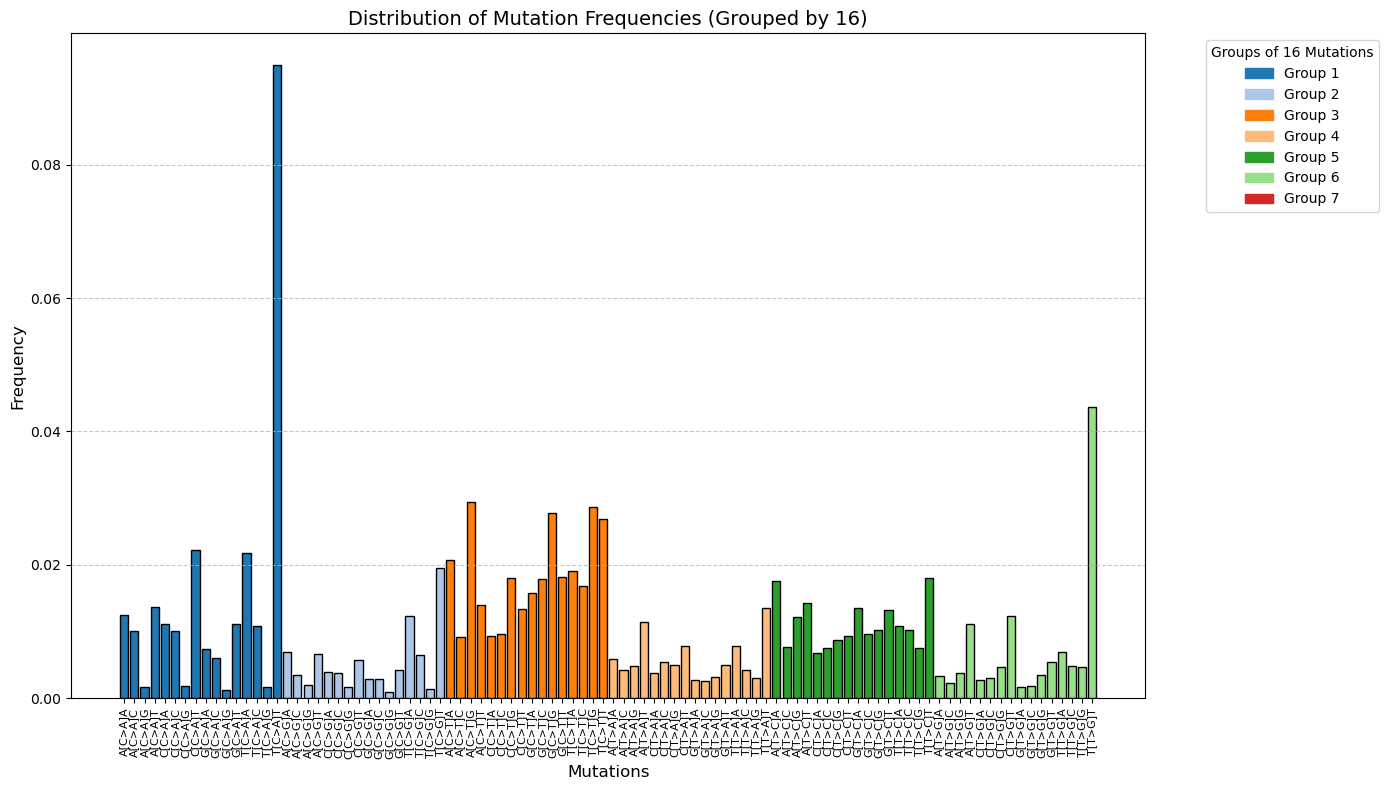

In [4]:
# Calculate the total counts for each mutation across patients
mutation_sums = data.sum(axis=1)

# Convert counts to frequencies
mutation_frequencies = mutation_sums / mutation_sums.sum()

# Group mutations into sets of 16 for coloring
num_groups = (len(mutation_frequencies) // 16) + 1
colors = plt.cm.tab20.colors  # Use a colormap with distinct colors

# Assign a color to each group of 16
bar_colors = [colors[i // 16 % len(colors)] for i in range(len(mutation_frequencies))]

# Plot the histogram
plt.figure(figsize=(14, 8))
bars = plt.bar(
    mutation_frequencies.index,
    mutation_frequencies.values,
    color=bar_colors,
    edgecolor="black",
)

# Customizing the x-axis for readability
plt.xticks(rotation=90, fontsize=8)
plt.title("Distribution of Mutation Frequencies (Grouped by 16)", fontsize=14)
plt.xlabel("Mutations", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add legend for groups of 16
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(num_groups)]
labels = [f"Group {i+1}" for i in range(num_groups)]
plt.legend(handles, labels, title="Groups of 16 Mutations", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()


In [7]:
losses = []
errors = []
from functions import *
iterations = 10



for i in range(iterations):

    data = pd.read_csv("data/GEL_data/catalogues_Ovary_SBS.tsv", sep="\t")
    # We need to transpose the data because the colums contain the patient data and the rows contain the specifc mutations
    train, test = train_test_split(data.T, test_size=0.2, shuffle=True)


    train = train.T
    test = test.T

    print(train.shape)
    print(test.shape)

    autoencoder = AE_NMF.AE_NMF(input_dim = train.shape[1], latent_dim = 4, constraint= 'pg')

    result = AE_NMF.train(model = autoencoder,
                        training_data = train,
                        criterion = torch.nn.MSELoss(reduction = 'mean'),
                        optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4),
                        tol =  1e-10,
                        relative_tol=True,
                        max_iter = 10_000_000)

    loss = result[1]
    signature = result[2]
    exposures_train = result[3]
    enc_mat = result[4]

    data1 = signature@exposures_train

    data = pd.DataFrame(data1, columns=train.columns)

    losses.append(loss[-1])


    diagonals_AE = signature.sum(axis = 0)
    exposures_AE = np.diag(diagonals_AE)@exposures_train
    signatures_AE = (signature)@np.diag(1/diagonals_AE)

    out_error_AE = reconstruction_error(test, signatures_AE)
    errors.append(out_error_AE)

print(np.mean(losses))
print(np.mean(errors))

(96, 418)
(96, 105)
(96, 418)
(96, 105)
(96, 418)
(96, 105)
(96, 418)
(96, 105)
(96, 418)
(96, 105)
(96, 418)
(96, 105)
(96, 418)
(96, 105)
(96, 418)
(96, 105)
(96, 418)
(96, 105)
(96, 418)
(96, 105)
1920360.140625
5344428.622043918


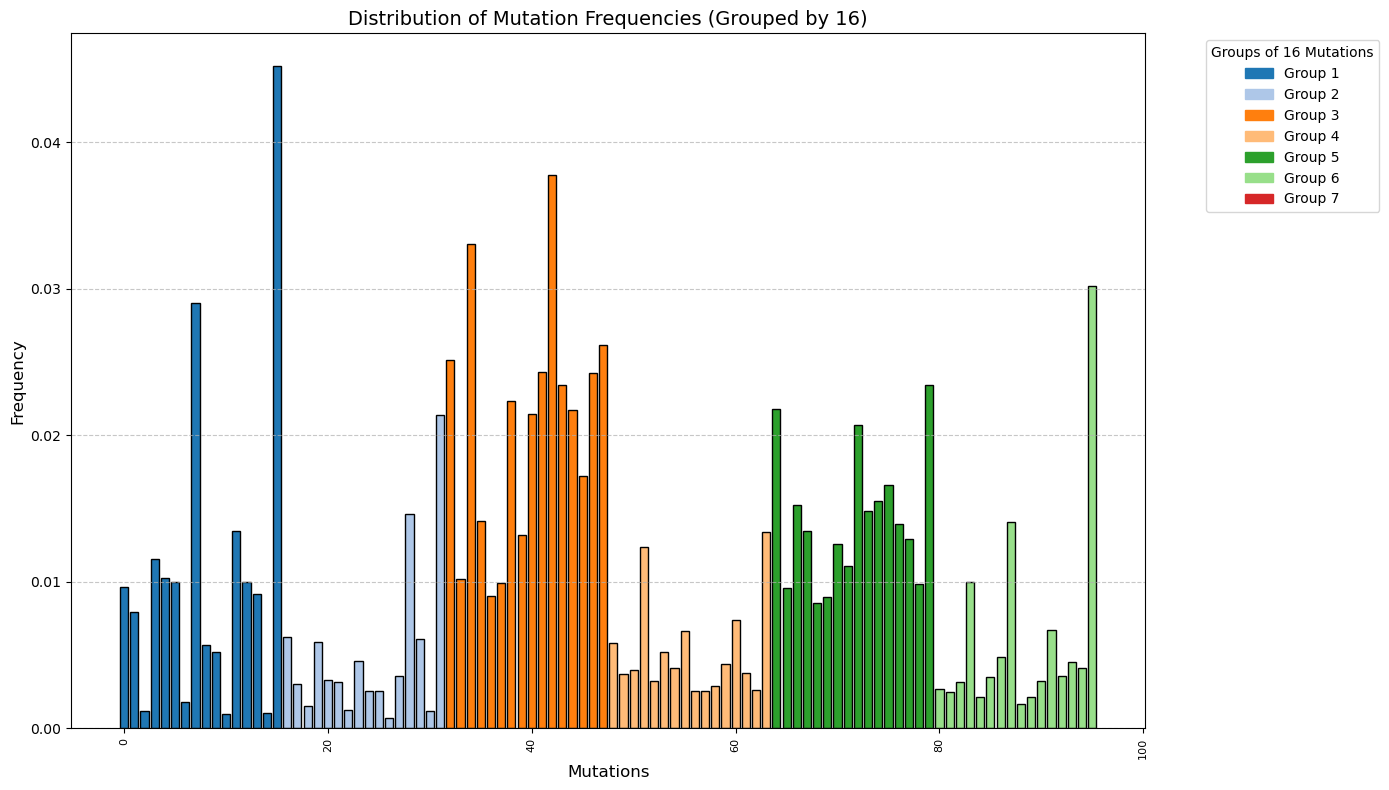

In [8]:
data1 = signature@exposures_train

data = pd.DataFrame(data1, columns=train.columns)

# Calculate the total counts for each mutation across patients
mutation_sums = data.sum(axis=1)

# Convert counts to frequencies
mutation_frequencies = mutation_sums / mutation_sums.sum()

# Group mutations into sets of 16 for coloring
num_groups = (len(mutation_frequencies) // 16) + 1
colors = plt.cm.tab20.colors  # Use a colormap with distinct colors

# Assign a color to each group of 16
bar_colors = [colors[i // 16 % len(colors)] for i in range(len(mutation_frequencies))]

# Plot the histogram
plt.figure(figsize=(14, 8))
bars = plt.bar(
    mutation_frequencies.index,
    mutation_frequencies.values,
    color=bar_colors,
    edgecolor="black",
)

# Customizing the x-axis for readability
plt.xticks(rotation=90, fontsize=8)
plt.title("Distribution of Mutation Frequencies (Grouped by 16)", fontsize=14)
plt.xlabel("Mutations", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add legend for groups of 16
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(num_groups)]
labels = [f"Group {i+1}" for i in range(num_groups)]
plt.legend(handles, labels, title="Groups of 16 Mutations", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
# # Compute the error between the original and reconstructed data for the training set

# error = np.linalg.norm(train_data.values - data1, ord='fro')

# print(f"Error: {error}")

In [10]:
from scipy.optimize import nnls

def refit(data, signatures, mean = True):
    """
    Refits the given data using the provided signatures.

    Parameters:
    data (DataFrame): Input data.
    signatures (numpy.ndarray): Signatures matrix.
    mean (bool): If True, computes mean squared error, else computes total squared error (default is True).

    Returns:
    float: Reconstruction error.
    """
    max_iter = signatures.shape[1]*30
    exposures = data.apply(lambda x: nnls(A = signatures, b = x, maxiter = max_iter)[0], axis = 0)
    rec = exposures.T@signatures.T
    denominator = np.prod(data.shape) if mean else 1
    out_error = np.linalg.norm(data.to_numpy() - rec.T)**2/denominator  
    return(out_error)


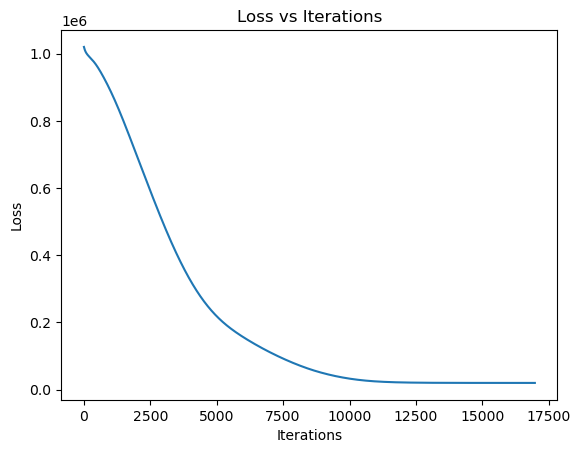

Last Loss:  19990.38671875


In [11]:
loss = result[1]

# plot the loss

plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()

print("Last Loss: ", loss[-1])

In [12]:

diagonals_AE = signature.sum(axis = 0)
exposures_AE = np.diag(diagonals_AE)@exposures_train
signatures_AE = (signature)@np.diag(1/diagonals_AE)

out_error_AE = refit(test, signatures_AE)

print(f"Error: {out_error_AE}")

Error: 11753512.574027209


In [ ]:


print(reconstruction_error(test, signatures_AE))

11753512.57402721


In [13]:
print(signature.shape)

(96, 4)
